# CS 6220 Data Mining — Assignment 4
### Yuanxun Qin
### timothyq
### qin.yuan@northeastern.edu

In [1]:
!curl https://course.ccs.neu.edu/cs6220/homework-4/data/f150_motor_distributors.txt >> f150_motor_distributors.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  249k  100  249k    0     0   322k      0 --:--:-- --:--:-- --:--:--  322k


In [2]:
import pandas as pd
import numpy as np



In [3]:
df = pd.read_csv("f150_motor_distributors.txt")
df.columns = ["ts", "gap"]

In [4]:
df

,ts,gap
0,-26.961416,-6.962109
1,-12.915849,-1.378941
2,22.476144,2.066612
3,-13.146631,4.835322
4,36.851734,2.470103
...,...,...
4994,6.852668,1.549076
4995,-2.340729,-7.343469
4996,12.925503,-0.103197
4997,-34.336778,4.405753


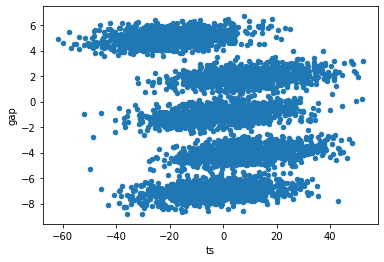

In [5]:
import matplotlib.pyplot as plt
df.plot.scatter(x='ts', y='gap')
plt.show()

## 1. K-Means
### 1a. Implementation

In [6]:
class MyKMeans:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, init_centroids=None):
        if init_centroids is None:
            # randomly initialize cluster centroids
            self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        else:
            # use specified initial centroids
            self.centroids = init_centroids

        for i in range(self.max_iter):
            # assign each data point to the nearest cluster
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            # print((X - self.centroids[:, np.newaxis]).shape)
            # print(X.shape)
            labels = np.argmin(distances, axis=0)

            # update cluster centroids to the mean of the assigned data points
            for j in range(self.n_clusters):
                self.centroids[j] = X[labels == j].mean(axis=0)

    def predict(self, X):
        # assign each data point to the nearest cluster
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        return labels

In [7]:
km = MyKMeans(5)
initial = np.array([[10,-10,2,3,-3],[10,-10,2,3,-3]]).T
km.fit(df.values,initial)
labels = km.predict(df.values)

### 1b. Scatter the results

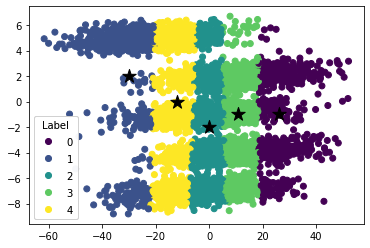

In [8]:
# generate a colormap
n_labels = len(np.unique(labels))
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label
fig, ax = plt.subplots()
scatter = ax.scatter(df['ts'], df['gap'], c=labels, cmap=cmap)
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Label")
ax.add_artist(legend1)

plt.show()

### Compare to the sklearn result

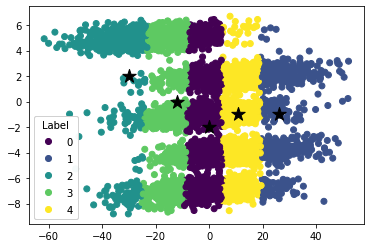

In [9]:
from sklearn.cluster import KMeans
skkm = KMeans(n_clusters=5)
labels_sk = skkm.fit_predict(df.values)

n_labels = len(np.unique(labels_sk))
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label
fig, ax = plt.subplots()
scatter = ax.scatter(df['ts'], df['gap'], c=labels_sk, cmap=cmap)
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Label")
ax.add_artist(legend1)

plt.show()

### 1c. You will notice that in the above, there are only five initialization clusters. Why is k = 5 a logical choice for this dataset? After plotting your resulting clusters, what do you notice? Did it cluster very well? Is there an initialization that would make it cluster well?
Answer: There are several methods for selecting k, such as the elbow method or silhouette method, which rely on evaluating the clustering performance for different values of k.

In this case, as the data is only two dimentional, we can easily observe the pattern and choose k = 5 by intuition.
The cluster is not as excepted, or not very well.

No initialization can help as the it will alway converge to similiar result.

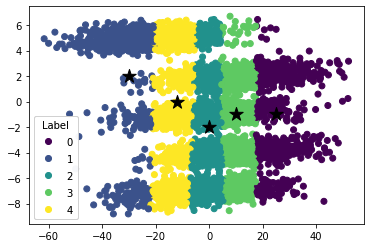

In [10]:
# Use a sets of initial centroids which scatter across the Y coordinate, and limit the iteration as only 10. We can still see the similiar result.
initial = np.array([[10,-10,-2,3,-6],[0,0,0,0,0]]).T
km = MyKMeans(5, 10)
km.fit(df.values,initial)
labels = km.predict(df.values)

# generate a colormap
n_labels = len(np.unique(labels))
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label
fig, ax = plt.subplots()
scatter = ax.scatter(df['ts'], df['gap'], c=labels, cmap=cmap)
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Label")
ax.add_artist(legend1)

plt.show()

## 2. Mahalanobis Distance


### 2a. Using the same data as Question 1 and the same initialization instances { x<sub>1</sub> , x<sub>2</sub> , x<sub>3</sub> , x<sub>4</sub> , x<sub>5</sub> } implement a specialized k-means with the above Mahalanobis Distance. Scatter the results with the different clusters as different colors.

### What do you notice? You may want to pre-compute $P^{-1}$ so that you aren’t calculating an inverse every single loop of the the k-Means algorithm.

### Answer: The result is much better than the 1. K-Mean solution



In [11]:
P = np.array([[10, 0.5], [-10,0.25]])
R = np.linalg.inv(P.T @ P) 
R

array([[ 0.00555556, -0.04444444],
       [-0.04444444,  3.55555556]])

In [12]:
class KMeansWithMD:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, D, init_centroids=None):
        if init_centroids is None:
            # randomly initialize cluster centroids
            self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        else:
            # use specified initial centroids
            self.centroids = init_centroids

        for i in range(self.max_iter):
            # assign each data point to the nearest cluster
            # distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            DXY = X - self.centroids[:, np.newaxis] # Brocast to (k, n, d)
            distances = np.zeros((self.n_clusters, len(X)))
            for ic in range(self.n_clusters):
                for inn in range(len(X)):
                    distances[ic][inn] = DXY[ic][inn][:, np.newaxis].T @ D @ DXY[ic][inn][:, np.newaxis]

            labels = np.argmin(distances, axis=0)

            # update cluster centroids to the mean of the assigned data points
            for j in range(self.n_clusters):
                self.centroids[j] = X[labels == j].mean(axis=0)

    def predict(self, X, D):
        # assign each data point to the nearest cluster
        distances = np.zeros((self.n_clusters, len(X)))
        DXY = X - self.centroids[:, np.newaxis] # Brocast to (k, n, d)
        for ic in range(self.n_clusters):
            for inn in range(len(X)):
                distances[ic][inn] = DXY[ic][inn][:, np.newaxis].T @ D @ DXY[ic][inn][:, np.newaxis]
        labels = np.argmin(distances, axis=0)
        return labels

In [13]:
arr = np.random.rand(3, 4, 2)
arr[0][0][:,np.newaxis].T.shape

(1, 2)

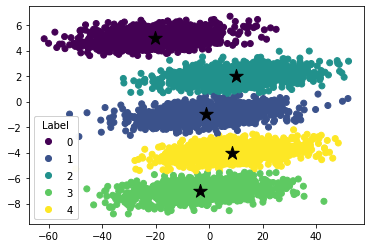

In [14]:
km = KMeansWithMD(n_clusters=5)
km.fit(df.values, R)
labels_sk = km.predict(df.values, R)

n_labels = len(np.unique(labels_sk))
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label
fig, ax = plt.subplots()
scatter = ax.scatter(df['ts'], df['gap'], c=labels_sk, cmap=cmap)
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Label")
ax.add_artist(legend1)

plt.show()

### 2b. Calculate and print out the principle components of the aggregate data.

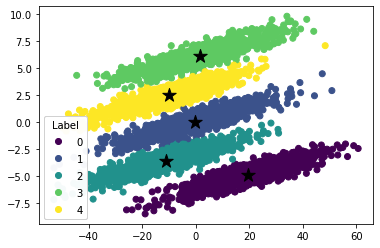

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# Fit the PCA object to the data
pca.fit(df.values)

# Transform the data using the PCA object
X_transformed = pca.transform(df.values)
centroids_transformed = pca.transform(km.centroids)

n_labels = len(np.unique(labels_sk))
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label
fig, ax = plt.subplots()
scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
ax.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Label")
ax.add_artist(legend1)

plt.show()

Text(0.5, 1.0, "use the cluster 4's principle component to transform all the data")

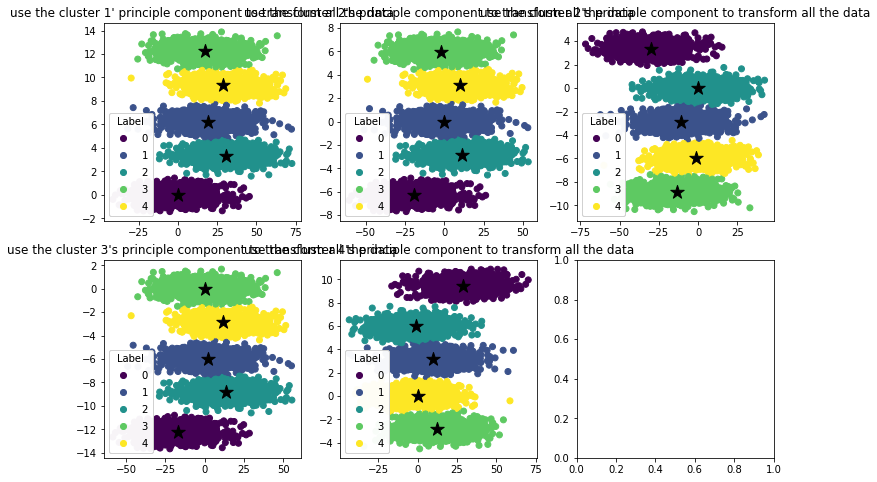

In [18]:
# create a figure with 5 subplots arranged in a 2x3 grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# create a PCA object for c0 and fit the data
c0_data = df.values[labels_sk == 0]
pca0 = PCA(n_components=2)
pca0.fit(c0_data)

# transform all the data using the c0's principal components
X_transformed = pca0.transform(df.values)

# transform the centroids
centroids_transformed = pca0.transform(km.centroids)

# get the number of unique labels
n_labels = len(np.unique(labels_sk))

# set up the colormap
cmap = plt.cm.get_cmap('viridis', n_labels)

# plot the data with colors based on label for c0
scatter = axs[0, 0].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
axs[0, 0].scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = axs[0, 0].legend(*scatter.legend_elements(),
                          loc="lower left", title="Label")
axs[0, 0].add_artist(legend1)
axs[0, 0].set_title('use the cluster 1\' principle component to transform all the data')

# create a PCA object for c1 and fit the data
c1_data = df.values[labels_sk == 1]
pca1 = PCA(n_components=2)
pca1.fit(c1_data)

# transform all the data using the c1's principal components
X_transformed = pca1.transform(df.values)

# transform the centroids
centroids_transformed = pca1.transform(km.centroids)

# plot the data with colors based on label for c1
scatter = axs[0, 1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
axs[0, 1].scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = axs[0, 1].legend(*scatter.legend_elements(),
                          loc="lower left", title="Label")
axs[0, 1].add_artist(legend1)
axs[0, 1].set_title('use the cluster 2\'s principle component to transform all the data')

# create a PCA object for c2 and fit the data
c2_data = df.values[labels_sk == 2]
pca2 = PCA(n_components=2)
pca2.fit(c2_data)

# transform all the data using the c2's principal components
X_transformed = pca2.transform(df.values)

# transform the centroids
centroids_transformed = pca2.transform(km.centroids)

# plot the data with colors based on label for c2
scatter = axs[0, 2].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
axs[0, 2].scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = axs[0, 2].legend(*scatter.legend_elements(),
                          loc="lower left", title="Label")
axs[0, 2].add_artist(legend1)
axs[0, 2].set_title('use the cluster 2\'s principle component to transform all the data')

# create a PCA object for c3 and fit the data
c3_data = df.values[labels_sk == 3]
pca3 = PCA(n_components=2)
pca3.fit(c3_data)

# transform all the data using the c3's principal components
X_transformed = pca3.transform(df.values)

# transform the centroids
centroids_transformed = pca3.transform(km.centroids)

# plot the data with colors based on label for c3
scatter = axs[1, 0].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
axs[1, 0].scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = axs[1, 0].legend(*scatter.legend_elements(),
                          loc="lower left", title="Label")
axs[1, 0].add_artist(legend1)
axs[1, 0].set_title('use the cluster 3\'s principle component to transform all the data')

# create a PCA object for c4 and fit the data
c4_data = df.values[labels_sk == 4]
pca4 = PCA(n_components=2)
pca4.fit(c4_data)

# transform all the data using the c4's principal components
X_transformed = pca4.transform(df.values)

# transform the centroids
centroids_transformed = pca4.transform(km.centroids)

# plot the data with colors based on label for c4
scatter = axs[1, 1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels_sk, cmap=cmap)
axs[1, 1].scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], marker='*', s=200, color='black', label='Centroids')
legend1 = axs[1, 1].legend(*scatter.legend_elements(),
                          loc="lower left", title="Label")
axs[1, 1].add_artist(legend1)
axs[1, 1].set_title('use the cluster 4\'s principle component to transform all the data')


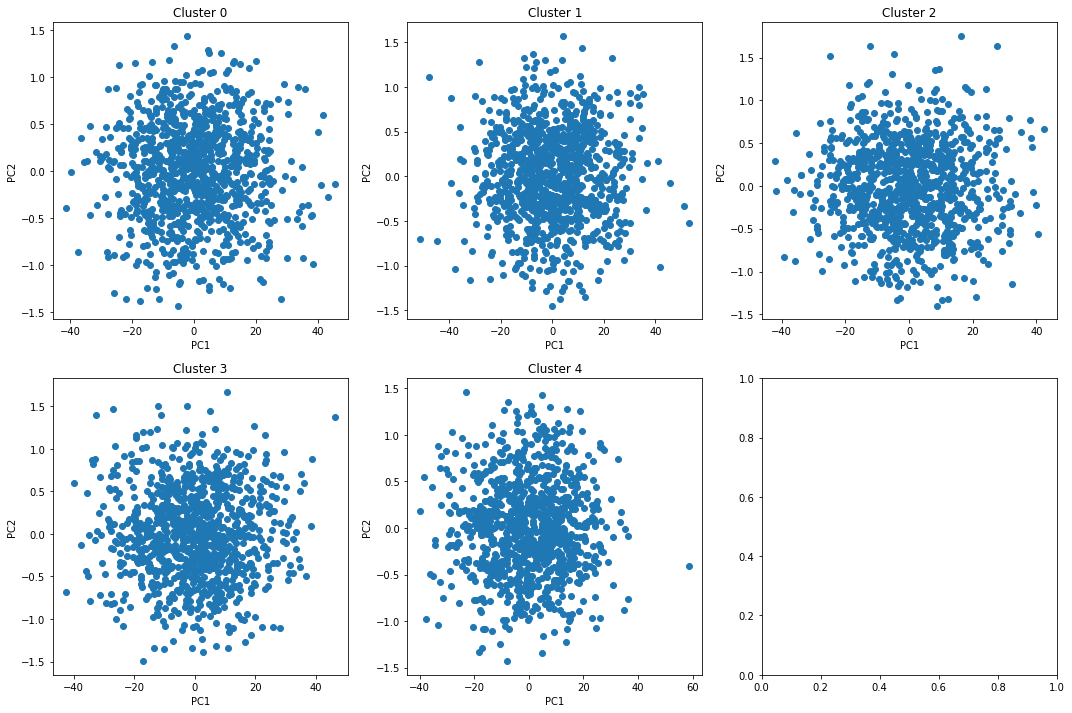

In [19]:
# fit PCA to each cluster separately and plot the transformed data for each cluster
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
n_labels = len(np.unique(labels_sk))
cmap = plt.cm.get_cmap('viridis', n_labels)

for i, label in enumerate(range(n_labels)):
    c_data = df.values[labels_sk == label]
    pca = PCA(n_components=2)
    pca.fit(c_data)
    X_transformed = pca.transform(c_data)

    # plot the transformed data for the current cluster
    axs[i // 3, i % 3].scatter(X_transformed[:, 0], X_transformed[:, 1])
    axs[i // 3, i % 3].set_xlabel('PC1')
    axs[i // 3, i % 3].set_ylabel('PC2')
    axs[i // 3, i % 3].set_title(f'Cluster {label}')
    
plt.show()


The PCA of individuals is not the same as the aggregated data. When the eigenvalues and the eigenvector are similiar, the means are quiet different. That's the reason when we use one of the transfomations we can get the similiar result in the previous cell. 

### 2d.) 

In [20]:
P = np.array([[10, 0.5], [-10, 0.25]])
eigenvalues, eigenvectors = np.linalg.eig(P)
D = np.diag(eigenvalues)
V = eigenvectors
P_n = V @ D
P_n

array([[ 6.4054879 , -0.04300577],
       [-6.95724558,  0.79190224]])

Given a covariance matrix C and its eigenvector matrix V, the product λ * v, where λ is an eigenvalue and v is its corresponding eigenvector, represents the direction and magnitude of the maximum variance of the data along that eigenvector.

new_data_transformed = (new_data - means) @ C

When we multiply each principal component by its corresponding eigenvalue λ, we obtain the amount of variance that is captured by that principal component. 

original_data = transformed_data @ C.T + means

Therefore, the relationship between λ * v and the original data is that λ * v represents the direction and amount of variance captured by the corresponding principal component of the original data.

The transformation matrix represents a linear transformation that scales the data along two directions, defined by its eigenvectors, and the amount of scaling is determined by its eigenvalues. This transformation can be used to transform the data into a new coordinate system where the axes correspond to the eigenvectors of the transformation matrix, and the variance of the data along each axis is given by the corresponding eigenvalue. This can be useful in data analysis, as it allows for easier visualization and interpretation of the data, as well as for dimensionality reduction and feature selection.

P_n(V@D) performs a change of basis to a coordinate system where the transformation performed by the matrix is diagonal. This means that in the new coordinate system, the matrix performs a scaling operation along each axis, where the scale factors are given by the diagonal elements of D.

Assuming that the data is arranged in a matrix X, where each row represents a sample and each column represents a feature, we can use P_n to perform a linear transformation of the data into a new coordinate system where the dimensions (i.e., features) are aligned with the eigenvectors of X.T @ X. Specifically, if we let Y = X @ P_n, then the columns of Y will represent the data transformed into the new coordinate system, where the first column corresponds to the direction of highest variance in the data, the second column corresponds to the direction of second-highest variance, and so on.

In [21]:
import numpy as np

# Define the matrix P
P = np.array([[10, 0.5], [-10, 0.25]])

# Calculate the eigenvectors and eigenvalues of P
eig_vals, eig_vecs = np.linalg.eig(P)

# Construct the diagonal matrix of eigenvalues
D = np.diag(eig_vals)

# Construct the matrix of eigenvectors
V = eig_vecs

# Normalize each eigenvector in V
V_normalized = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=V)

# Construct the matrix with orthonormal eigenvectors
P_orthonormal = V_normalized @ np.linalg.inv(V_normalized)

print("Original matrix P:\n", P)
print("Matrix with orthonormal eigenvectors:\n", P_orthonormal)


# Calculate the eigenvectors and eigenvalues of P
eig_vals, eig_vecs = np.linalg.eig(P_orthonormal)

# Construct the diagonal matrix of eigenvalues 
D = np.diag(eig_vals)

# Construct the matrix of eigenvectors 
V = eig_vecs

# Print the diagonal matrix of eigenvalues and eigenvectors 
print("Diagonal matrix of eigenvalues:\n", D) 
print("Eigenvectors:\n", V)

# Define the data matrix X
X = np.array([[1, 2, 3], [4, 5, 6]])

# Transform the data using the eigenvectors
X_transformed = V @ np.sqrt(D) @ X

# Print the transformed data
print("Transformed data:\n", X_transformed)

# Reconstruct the original data
X_reconstructed = np.linalg.inv(V @ np.sqrt(D)) @ X_transformed

# Print the reconstructed data
print("Reconstructed data:\n", X_reconstructed)


Original matrix P:
 [[ 10.     0.5 ]
 [-10.     0.25]]
Matrix with orthonormal eigenvectors:
 [[ 1.00000000e+00 -8.15985884e-18]
 [-8.42756479e-17  1.00000000e+00]]
Diagonal matrix of eigenvalues:
 [[1. 0.]
 [0. 1.]]
Eigenvectors:
 [[ 0.29711317 -0.99959179]
 [ 0.95484227 -0.02857002]]
Transformed data:
 [[-3.701254   -4.40373262 -5.10621124]
 [ 0.84056218  1.76683443  2.69310668]]
Reconstructed data:
 [[1. 2. 3.]
 [4. 5. 6.]]


However, as the relationship between P  and data is not a speccify, and the P = np.array([[10, 0.5], [-10, 0.25]]) doesn't have the propoties that could make the reconstruction simplified(eg. normalized matrix such that its eigenvecs are orthogonal then V^-1 == V.T). It doesn't make too much sense for the D @ V.

However, if we use the coverience matrix of the data as P, then we can perform PCA on the data by multiple V * sqrt(D) then we can get the normalized PCA.

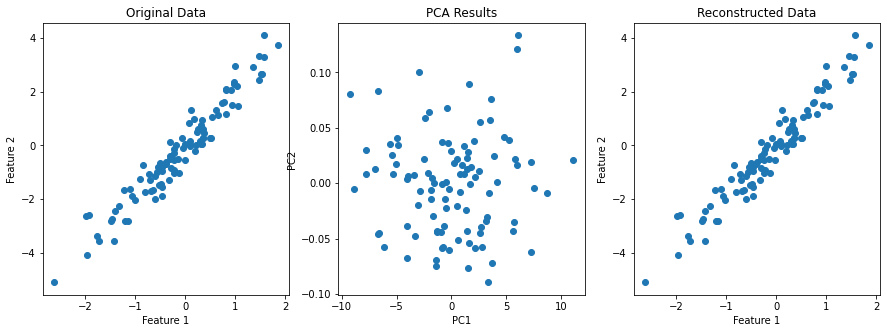

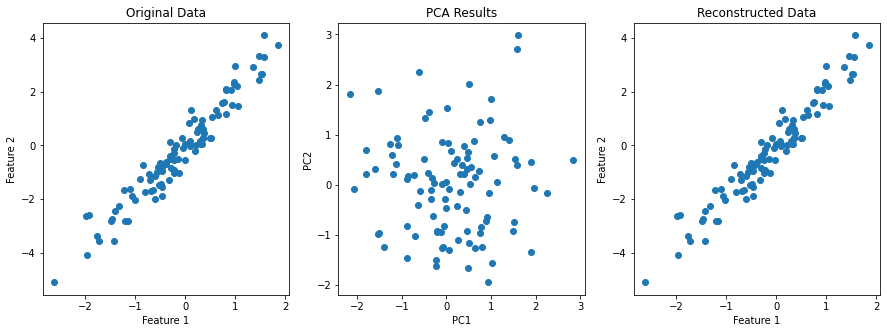

In [22]:

# Step 1: Generate example data
np.random.seed(42)
x1 = np.random.normal(loc=0.0, scale=1.0, size=100)
x2 = 2.0 * x1 + np.random.normal(loc=0.0, scale=0.5, size=100)
data = np.stack((x1, x2), axis=1)

# Step 2: Perform PCA on the data
mean_centered_data = data - np.mean(data, axis=0)
cov_matrix = np.cov(data.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)
sort_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]
transformed_data = np.dot(mean_centered_data, eigvecs)

# Step 3: Reconstruct the original data from the transformed data
reconstructed_data = np.dot(transformed_data, eigvecs.T) + np.mean(data, axis=0)

# Step 4: Plot the original data, PCA results, and reconstructed data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(data[:, 0], data[:, 1])
ax1.set_title("Original Data")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax2.scatter(transformed_data[:, 0] * np.sqrt(eigvals[0]), transformed_data[:, 1] * np.sqrt(eigvals[1]))
ax2.set_title("PCA Results")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax3.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1])
ax3.set_title("Reconstructed Data")
ax3.set_xlabel("Feature 1")
ax3.set_ylabel("Feature 2")
plt.show()




# Step 1: Generate example data and normalize it
np.random.seed(42)
x1 = np.random.normal(loc=0.0, scale=1.0, size=100)
x2 = 2.0 * x1 + np.random.normal(loc=0.0, scale=0.5, size=100)
data = np.stack((x1, x2), axis=1)
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_norm = (data - data_mean) / data_std
# data = data_norm

# Step 2: Perform PCA on the data
cov_matrix = np.cov(data.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)
sort_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]
transformed_data = np.dot(data, eigvecs / np.sqrt(eigvals))

# Step 3: Reconstruct the original data from the transformed data
reconstructed_data = np.dot(np.sqrt(eigvals) * transformed_data,  eigvecs.T)

# Step 4: Plot the original data, PCA results, and reconstructed data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(data[:, 0], data[:, 1])
ax1.set_title("Original Data")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax2.scatter(transformed_data[:, 0], transformed_data[:, 1])
ax2.set_title("PCA Results")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax3.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1])
ax3.set_title("Reconstructed Data")
ax3.set_xlabel("Feature 1")
ax3.set_ylabel("Feature 2")
plt.show()


## 3. Market Basket Analysis and Algorithms

### 3a.)
To obtain candidate 4-itemsets using the F k−1 × F 1 merging strategy, we need to merge each frequent k-1 itemset with a frequent 1-itemset that is not already in the k-1 itemset.

In this case, since we are looking for candidate 4-itemsets, k-1 = 3. Therefore, we need to merge each frequent 3-itemset in F3 with a frequent 1-itemset that is not already in the 3-itemset.

The frequent 1-itemsets are {1}, {2}, {3}, {4}, and {5}. We can merge each of these with each of the frequent 3-itemsets in F3 to obtain the following candidate 4-itemsets:

{1, 2, 3, 4}
{1, 2, 3, 5}
{1, 2, 4, 5}
{1, 3, 4, 5}
{2, 3, 4, 5}
Therefore, the candidate 4-itemsets obtained using the F k−1 × F 1 merging strategy are:

{1, 2, 3, 4}, {1, 2, 3, 5}, {1, 2, 4, 5}, {1, 3, 4, 5}, {2, 3, 4, 5}

### 3b.)
To obtain candidate 4-itemsets using the F k−1 × F k−1 merging strategy in Apriori, we need to merge each frequent k-1 itemset with another frequent k-1 itemset that is not already in the k-1 itemset.

In this case, since we are looking for candidate 4-itemsets, k-1 = 3. Therefore, we need to merge each frequent 3-itemset in F3 with another frequent 3-itemset in F3 that is not already in the 3-itemset.

In Apriori Algorithm, when merging Fk−1 × Fk−1 into Fk, only pairs that share the first k-2 items are considered. This is because the Apriori property states that any subset of a frequent itemset must also be frequent. Therefore, when merging Fk−1 × Fk−1 into Fk, only those pairs that share the first k-2 items can potentially form a frequent itemset of size k. This is because if a pair of itemsets does not share the first k-2 items, then at least one of them will contain an item that is not frequent in the dataset, and therefore cannot be a part of a frequent itemset of size k. By considering only pairs that share the first k-2 items, the Apriori algorithm avoids generating and counting many candidate itemsets that are guaranteed to be infrequent. This helps to reduce the search space and improve the efficiency of the algorithm.

The frequent 3-itemsets in F3 are {1, 2, 3}, {1, 2, 4}, {1, 2, 5}, {1, 3, 4}, {2, 3, 4}, {2, 3, 5}, and {3, 4, 5}.

We can merge each of these with each of the other frequent 3-itemsets in F3 that are not already in the 3-itemset to obtain the following candidate itemsets:

{1,2,3}x{1,2,4} : {1,2,3,4}

{1,2,3}x{1,2,5} : {1,2,3,5}

{1,2,4}x{1,2,5} : {1,2,4,5}

{2,3,4}x{2,3,5} : {2,3,4,5}


Therefore, the candidate 4-itemsets obtained using the F k−1 × F k−1 merging strategy in Apriori are:

{1, 2, 3, 4}, {1, 2, 3, 5}, {1, 2, 4, 5}, {2, 3, 4, 5}

### 3c.)
For each candidate 4-itemset, we need to check whether all of its subsets of size 3 are frequent. If a candidate 4-itemset has at least one subset of size 3 that is not frequent, then it cannot be a frequent itemset and is pruned.

The infrequent 3-itemsets are:

{1, 3, 5}, {2, 4, 5}

The candidate 4-itemsets are:

{1, 2, 3, 4}
Subsets of size 3: {1, 2, 3}, {1, 2, 4}, {1, 3, 4}, {2, 3, 4}.
All of its subsets of size 3 are frequent, so it survives.

{1, 2, 3, 5}
Subsets of size 3: {1, 2, 3}, {1, 2, 5}, {1, 3, 5}, {2, 3, 5}.
{1, 3, 5} is not frequent, so it is pruned.

{1, 2, 4, 5}
Subsets of size 3: {1, 2, 4}, {1, 2, 5}, {1, 4, 5}, {2, 4, 5}.
All of its subsets of size 3 are frequent, so it survives.

{2, 3, 4, 5}
Subsets of size 3: {2, 3, 4}, {2, 3, 5}, {2, 4, 5}, {3, 4, 5}.
{2, 4, 5} is not frequent, so it is pruned.

Therefore, the candidate 4-itemsets that survive the candidate pruning step of the Apriori algorithm are:

{1, 2, 3, 4}.

## 4
### 4a.)

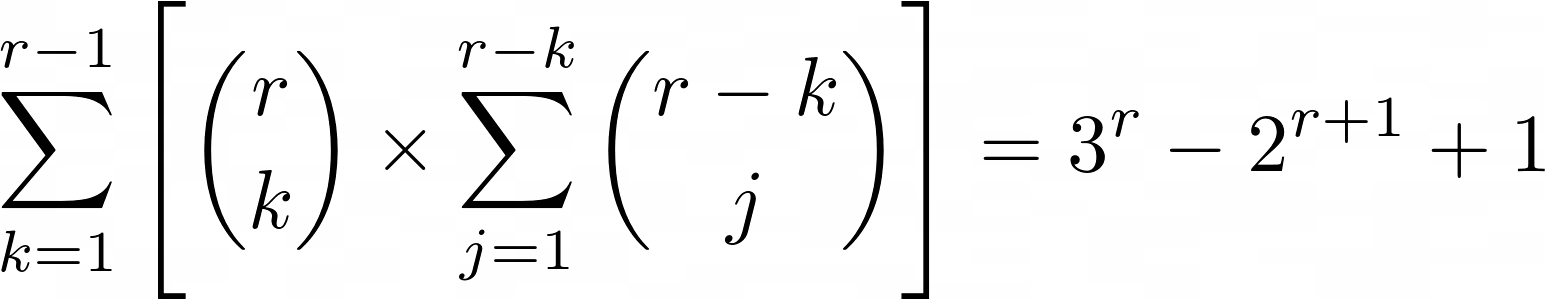

 the maximum number of association rules that can be extracted from the given data (including rules that have zero support) is:

3^7 - 2^{7+1} + 1 = 2187 - 256 + 1 = 1932.

Therefore, there are 1932 possible association rules that can be generated from the given data.

### 4b.) 
confidence({ Milk, Diapers } ⇒ { Butter }) = support({ Milk, Diapers, Butter }) / support({ Milk, Diapers })

We need to find the support of both the antecedent and the consequent of the rule.

The support of { Milk, Diapers } is the number of transactions that contain both Milk and Diapers, which is 4 in this case (transactions 2, 3, 5, and 7).

The support of { Milk, Diapers, Butter } is the number of transactions that contain all three items, which is 2 (transactions 2 and 7).

Therefore, the confidence of the rule { Milk, Diapers } ⇒ { Butter } is:

confidence({ Milk, Diapers } ⇒ { Butter }) = support({ Milk, Diapers, Butter }) / support({ Milk, Diapers })

= 2 / 4

= 0.5

So the confidence of the rule is 0.5 or 50%. This means that out of all transactions that contain both Milk and Diapers, 50% also contain Butter.

### 4c.) What is the support for the rule { Milk, Diapers } ⇒ { Butter }?

 the support for { Milk, Diapers, Butter } is 2 out of 10 transactions, or 0.2 (or 20%).

## 4d.) 
True

### 4e.)
False. 

Because even though { a,b,c } is a candidate itemset, it may not necessarily be a frequent itemset. It depends on the actual support count of the itemset in the dataset.

### 4f.)
False. If the {a,b} do not contain c and the {b, c} do not contain a, then the {b} will be at least 50.

### 4g.)
False.

The maximum number of size-2 frequent itemsets that can be extracted from a dataset with 5 items is actually 10.

Combination formula:

nCr = n! / r!(n-r)!

So, the number of size-2 frequent itemsets is:

nCr = 5C2 = 5! / 2!(5-2)! = 10




